# ---------------------- **Prediksi Harga Rumah** ----------------------
---

Notebook ini dibuat oleh Ghaffar Farros, bertujuan untuk melakukan prediksi harga rumah menggunakan data dari platform `pashouse`. Proses yang dilakukan meliputi pengumpulan data (web scraping), pembersihan data, eksplorasi, pemodelan dengan berbagai algoritma regresi, serta evaluasi performa model. 

## Introduction

### Background

Harga properti di Indonesia sangat dinamis dan dipengaruhi oleh banyak faktor seperti lokasi, luas bangunan, dan fasilitas lainnya. Namun, calon pembeli atau penjual sering kesulitan menentukan harga wajar karena ketiadaan alat estimasi berbasis data. Informasi harga yang tepat tidak hanya membantu penjual dan pembeli dalam pengambilan keputusan, tetapi juga dapat mendukung lembaga keuangan dan investor dalam menilai nilai aset properti.

Proyek ini akan membangun model prediksi harga rumah dengan memanfaatkan data riil dari marketplace properti `(pashouse)` untuk memberikan estimasi dengan objektif. Data yang diperoleh kemudian diproses dan dianalisis menggunakan beberapa teknik pemodelan untuk menghasilkan prediksi harga yang paling baik dan stabil, dengan menggunakan berbagai model termasuk regresi linier, regularisasi, hingga ensemble seperti Random Forest.

### Problem Statement
- Bagaimana karakteristik distribusi harga properti secara keseluruhan dan perbedaan harga antar kota?
- Faktor-faktor apa saja yang memiliki hubungan signifikan dengan harga properti?
- Bagaimana cara membangun model machine learning yang mampu memprediksi harga rumah secara objektif berdasarkan fitur-fitur properti?
- Metode machine learning apa yang paling efektif untuk menghasilkan prediksi harga rumah yang baik dan stabil berdasarkan data yang dimiliki saat ini?
- Komponen atau langkah apa saja yang dapat dioptimasi dalam proses pemodelan untuk mencapai model dengan performa baik dan generalisasi yang kuat (goodfit)?

### Objectives
- Menganalisis karakteristik distribusi harga properti secara keseluruhan dan perbedaan harga antar kota.
- Mengidentifikasi faktor-faktor yang memiliki hubungan signifikan dengan harga properti melalui analisis data.
- Mengembangkan model machine learning yang dapat memprediksi harga rumah secara objektif berdasarkan fitur-fitur properti.
- Mengevaluasi dan membandingkan metode machine learning untuk menentukan algoritma yang paling efektif dalam memprediksi harga rumah berdasarkan data yang tersedia.
- Mengoptimasi komponen dan langkah-langkah dalam proses pemodelan untuk menghasilkan model dengan performa baik dan kemampuan generalisasi yang kuat.



## Import Library

In [47]:
# data manipulation
import pandas as pd
import numpy as np
import re

# visual
import matplotlib.pyplot as plt
import seaborn as sns

# feature engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from feature_engine.outliers import Winsorizer

# Model
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Assumptions
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

## Data Loading

In [48]:
# Load the dataset
df = pd.read_csv('data_scraped.csv')
df

,Nama Rumah,Harga,Cicilan,Lokasi,Keterangan
0,Kebun Raya Residence Cluster Cipta Park 1,Rp 870.000.000,Cicilan 8.4 Juta/bulan,"Ciomas, Kabupaten bogor",LT 96 m²LB 54 m²KM 1KT 2
1,El Fatih Land Pancoran mas F1,Rp 960.000.000,Cicilan 9.2 Juta/bulan,"Pancoran mas, Kota depok",LT 72 m²LB 100 m²KM 2KT 3
2,Komplek Depkes,Rp 1.280.000.000,Cicilan 12.3 Juta/bulan,"Ciputat, Kota tangerang selatan",LT 125 m²LB 112 m²KM 3KT 3
3,Perumahan Taman Yasmin Sektor 1,Rp 1.140.000.000,Cicilan 11 Juta/bulan,"Bogor barat, Kota bogor",LT 91 m²LB 91 m²KM 1KT 2
4,Metland Cileungsi,Rp 1.530.000.000,Cicilan 14.7 Juta/bulan,"Cileungsi, Kabupaten bogor",LT 84 m²LB 99 m²KM 2KT 3
...,...,...,...,...,...
5835,Perumahan Citra 5,Rp 2.150.000.000,Cicilan 20.7 Juta/bulan,"Kalideres, Kota jakarta barat",LT 108 m²LB 123 m²KM 3KT 4
5836,Vida Bumi Pala Grand Bekasi,Rp 725.000.000,Cicilan 7 Juta/bulan,"Mustikajaya, Kota bekasi",LT 67 m²LB 47 m²KM 1KT 2
5837,Perumahan Cipta Graha Permai,Rp 785.000.000,Cicilan 7.5 Juta/bulan,"Cibinong, Kabupaten bogor",LT 84 m²LB 52 m²KM 1KT 2
5838,Griya Melati Mas,Rp 885.000.000,Cicilan 8.5 Juta/bulan,"Cilodong, Kota depok",LT 84 m²LB 57 m²KM 2KT 2


Berikut adalah data yang diperoleh dari hasil scraping dengan python pada web resmi pashouse. Data ini berisi informasi properti rumah dengan beberapa atribut utama, yaitu:
- Nama Rumah : Identifikasi atau nama cluster/perumahan
- Harga  : Harga jual rumah dalam format mata uang rupiah -       `(masih campuran angka-huruf, belum berupa integer)`
- Cicilan:  Informasi cicilan per bulan dengan nilai dan satuan -        `(perlu ekstraksi angka agar bisa dianalisis numerik)`
- Lokasi:        Lokasi geografis rumah, terdiri dari nama kecamatan dan kota/kabupaten -      `(terdiri dari dua tingkat wilayah, perlu dipisah ke kolom berbeda)`
- Keterangan:    Detail spesifikasi rumah seperti Luas Tanah (LT), Luas Bangunan (LB), Jumlah Kamar Mandi (KM), dan Jumlah Kamar Tidur (KT) -      `(masih berupa teks terformat, perlu dipisahkan ke kolom-kolom terpisah)`

Kondisi data saat ini Data masih mentah dan belum bersih (contoh: harga dan cicilan masih dalam format teks campuran angka dan huruf), informasi keterangan berupa gabungan atribut teknis yang perlu diurai dan distandarisasi, dan lainnya yang menunjukkan data ini belum siap pakai. Selanjutnya akan dibersihkan dan membuat data menjadi siap pakai.


## Data Cleaning

### Raw Data Processing

In [49]:
# Clean kolom Keterangan
def extract_value(text, key):
    if not isinstance(text, str):
        return None
    match = re.search(fr"{key} (\d+)", text)
    return int(match.group(1)) if match else None

df["Luas Tanah"] = df["Keterangan"].apply(lambda x: extract_value(x, "LT"))
df["Luas Bangunan"] = df["Keterangan"].apply(lambda x: extract_value(x, "LB"))
df["Kamar Mandi"] = df["Keterangan"].apply(lambda x: extract_value(x, "KM"))
df["Kamar Tidur"] = df["Keterangan"].apply(lambda x: extract_value(x, "KT"))

df = df.drop(columns=["Keterangan"])

# Clean kolom Harga
def clean_price(price):
    return int(re.sub(r"[^\d]", "", price))

df["Harga"] = df["Harga"].apply(clean_price)

# Clean kolom Lokasi
df[["Lokasi", "Kota"]] = df["Lokasi"].str.split(", ", expand=True)
df[["Tipe", "Kota"]] = df["Kota"].str.split(n=1, expand=True)

# Clean kolom Cicilan
def convert_cicilan(value):
    value = value.replace('Cicilan ', '').replace(' Juta/bulan', '')
    return int(float(value) * 1_000_000)

df['Cicilan'] = df['Cicilan'].apply(convert_cicilan)

# Order
df = df[["Nama Rumah", "Harga", "Cicilan","Lokasi", "Kota","Tipe", "Luas Tanah", "Luas Bangunan", "Kamar Mandi", "Kamar Tidur"]]

In [50]:
df.head()

,Nama Rumah,Harga,Cicilan,Lokasi,Kota,Tipe,Luas Tanah,Luas Bangunan,Kamar Mandi,Kamar Tidur
0,Kebun Raya Residence Cluster Cipta Park 1,870000000,8400000,Ciomas,bogor,Kabupaten,96.00000,54.00000,1.00000,2.00000
1,El Fatih Land Pancoran mas F1,960000000,9200000,Pancoran mas,depok,Kota,72.00000,100.00000,2.00000,3.00000
2,Komplek Depkes,1280000000,12300000,Ciputat,tangerang selatan,Kota,125.00000,112.00000,3.00000,3.00000
3,Perumahan Taman Yasmin Sektor 1,1140000000,11000000,Bogor barat,bogor,Kota,91.00000,91.00000,1.00000,2.00000
4,Metland Cileungsi,1530000000,14700000,Cileungsi,bogor,Kabupaten,84.00000,99.00000,2.00000,3.00000


### Data Type

In [51]:
print("======== DataFrame Info Sebelum ========")
print("")
df.info()

======== DataFrame Info Sebelum ========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Nama Rumah     5790 non-null   object 
 1   Harga          5840 non-null   int64  
 2   Cicilan        5840 non-null   int64  
 3   Lokasi         5790 non-null   object 
 4   Kota           5790 non-null   object 
 5   Tipe           5790 non-null   object 
 6   Luas Tanah     5790 non-null   float64
 7   Luas Bangunan  5790 non-null   float64
 8   Kamar Mandi    5790 non-null   float64
 9   Kamar Tidur    5790 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 456.4+ KB


In [52]:
# Penyesuaian tipe data

df = df.astype({
    "Luas Tanah": "Int64",
    "Luas Bangunan": "Int64",
    "Kamar Mandi": "Int64",
    "Kamar Tidur": "Int64"
})

In [53]:
print("======== DataFrame info Sesudah ========")
print("")
df.info()

======== DataFrame info Sesudah ========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Nama Rumah     5790 non-null   object
 1   Harga          5840 non-null   int64 
 2   Cicilan        5840 non-null   int64 
 3   Lokasi         5790 non-null   object
 4   Kota           5790 non-null   object
 5   Tipe           5790 non-null   object
 6   Luas Tanah     5790 non-null   Int64 
 7   Luas Bangunan  5790 non-null   Int64 
 8   Kamar Mandi    5790 non-null   Int64 
 9   Kamar Tidur    5790 non-null   Int64 
dtypes: Int64(4), int64(2), object(4)
memory usage: 479.2+ KB


### Duplicated

In [54]:
# Drop data duplikat

print("Sebelum drop:", df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)
print("Sesudah drop:", df.duplicated().sum())

Sebelum drop: 28
Sesudah drop: 0


### Missing Value 

In [55]:
# Missing Value
print("==== Missing values ====\n",df.isnull().sum())
df = df.dropna().reset_index(drop=True)
print("========= Setelah Drop =========\n",df.isnull().sum())

==== Missing values ====
 Nama Rumah       50
Harga             0
Cicilan           0
Lokasi           50
Kota             50
Tipe             50
Luas Tanah       50
Luas Bangunan    50
Kamar Mandi      50
Kamar Tidur      50
dtype: int64
========= Setelah Drop =========
 Nama Rumah       0
Harga            0
Cicilan          0
Lokasi           0
Kota             0
Tipe             0
Luas Tanah       0
Luas Bangunan    0
Kamar Mandi      0
Kamar Tidur      0
dtype: int64


Untuk mempersiapkan data properti agar siap digunakan dalam analisis dan pemodelan machine learning, dilakukan serangkaian tahapan preprocessing sebagai berikut:

**1. Penyusunan Tabel Siap Pakai**

Tabel data disusun dengan kolom-kolom utama berikut: `Nama Rumah`, `Harga`, `Cicilan`, `Lokasi`, `Kota`, `Tipe`, `Luas Tanah`, `Luas Bangunan`, `Kamar Mandi`, dan `Kamar Tidur`.

**2. Penyesuaian Tipe Data**
- Semua kolom numerik seperti Harga, Cicilan, Luas Tanah, Luas Bangunan, Kamar Mandi, dan Kamar Tidur diubah ke tipe data **integer** untuk memudahkan analisis numerik dan pemodelan.  
- Kolom teks seperti Nama Rumah, Lokasi, Kota, dan Tipe dibiarkan sebagai tipe string (object).

**3. Penanganan Data Duplikat**
- Ditemukan **28 baris data duplikat** yang dihapus dari dataset untuk menghindari bias pada model machine learning.

**4. Penanganan Missing Value**
- Baris data yang mengandung nilai hilang (missing values) juga dihapus untuk memastikan integritas data dan kinerja model ML yang optimal.

Dengan preprocessing ini, dataset menjadi bersih, terstruktur, dan siap untuk langkah analisis lanjutan maupun pemodelan prediktif.


## Exploratory Data Analysis

In [56]:
df.head()

,Nama Rumah,Harga,Cicilan,Lokasi,Kota,Tipe,Luas Tanah,Luas Bangunan,Kamar Mandi,Kamar Tidur
0,Kebun Raya Residence Cluster Cipta Park 1,870000000,8400000,Ciomas,bogor,Kabupaten,96,54,1,2
1,El Fatih Land Pancoran mas F1,960000000,9200000,Pancoran mas,depok,Kota,72,100,2,3
2,Komplek Depkes,1280000000,12300000,Ciputat,tangerang selatan,Kota,125,112,3,3
3,Perumahan Taman Yasmin Sektor 1,1140000000,11000000,Bogor barat,bogor,Kota,91,91,1,2
4,Metland Cileungsi,1530000000,14700000,Cileungsi,bogor,Kabupaten,84,99,2,3


### Distribusi Harga Rumah

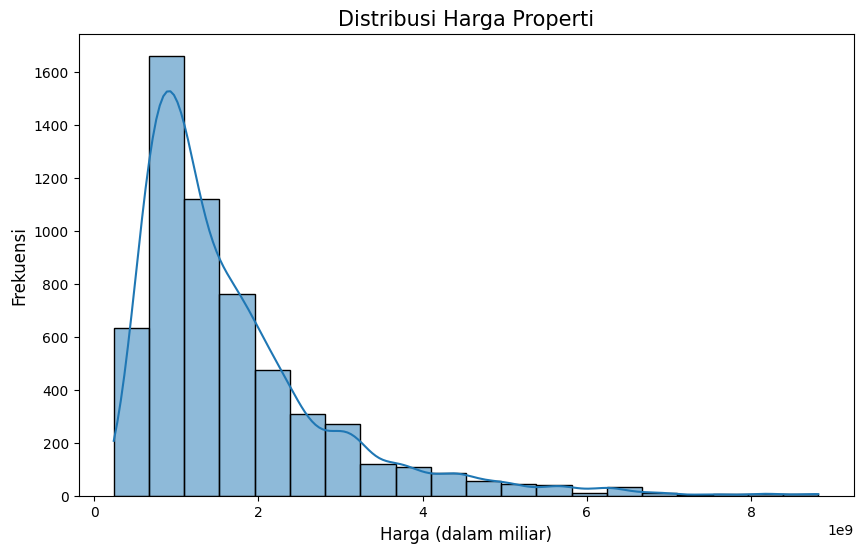

In [57]:
# Visualisasi distribusi harga properti
plt.figure(figsize=(10, 6))
sns.histplot(df['Harga'], bins=20, kde=True)
plt.title('Distribusi Harga Properti', fontsize=15)
plt.xlabel('Harga (dalam miliar)', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.show()

Visualisasi menunjukkan sebaran harga properti. Kebanyakan properti terkonsentrasi di harga tertentu yang bisa menjadi indikator harga pasar dominan yaitu di sekitar 1 Milliar Rupiah. Hal tersebut dapat dijadikan strategi penetapan harga, misalnya untuk pengembang dapat fokus mengembangkan unit dengan harga sekitar 1 miliar atau dibawahnya, karena terlihat sebagai sweet spot pasar. Informasi ini juga dapat dijadikan acuan harga di sekitaran Jabodetabek, membantu pembeli menilai apakah sebuah properti tergolong murah atau mahal.

### Rata-Rata Harga Properti

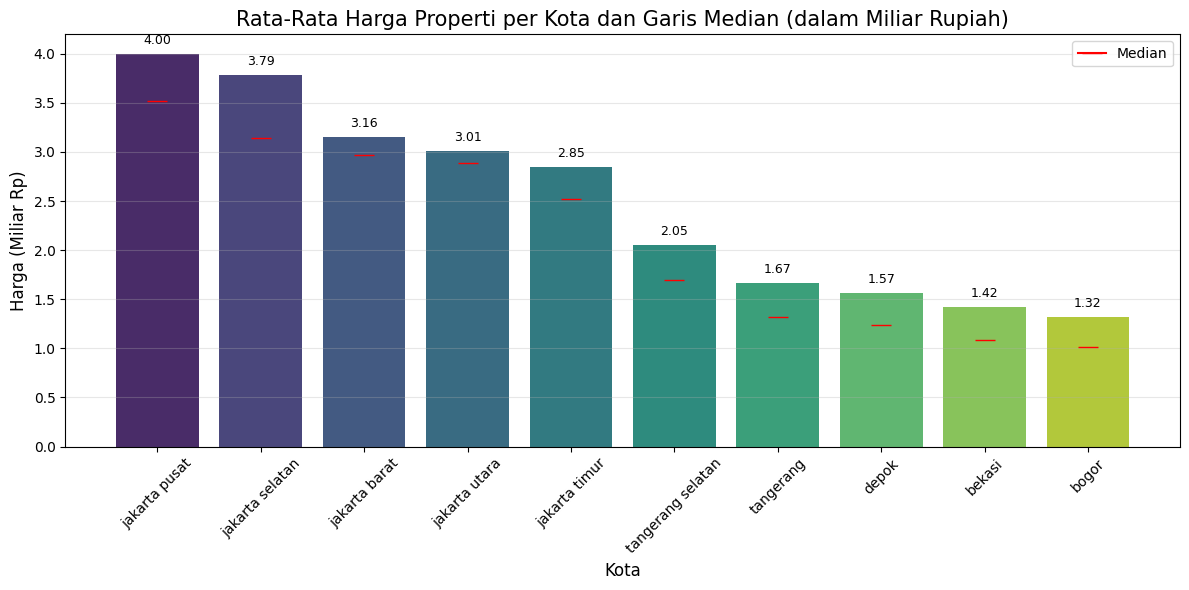

In [58]:
# Visualisasi rata-rata dan median harga properti per kota
avg_price = df.groupby('Kota')['Harga'].mean() / 1e9
median_price = df.groupby('Kota')['Harga'].median() / 1e9
avg_price = avg_price.sort_values(ascending=False)
median_price = median_price[avg_price.index]  # ikuti urutan mean

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=avg_price.index, y=avg_price.values, palette='viridis')
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(f'{height:.2f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', 
                fontsize=9, color='black', 
                xytext=(0, 5), textcoords='offset points')

for i, median in enumerate(median_price):
    ax.plot(i, median, marker='_', color='red', markersize=15, label='Median' if i == 0 else "")

plt.title('Rata-Rata Harga Properti per Kota dan Garis Median (dalam Miliar Rupiah)', fontsize=15)
plt.xlabel('Kota', fontsize=12)
plt.ylabel('Harga (Miliar Rp)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()


plt.legend()
plt.show()


Berdasarkan visualisasi heatmap rata-rata harga properti per kota, terlihat bahwa semua kota di provinsi Jakarta memiliki rata-rata harga properti tertinggi, semua berada di atas 2,5 miliar Rupiah. Hal ini mencerminkan statusnya sebagai pusat ekonomi dan bisnis dengan permintaan properti yang tinggi. Sementara itu, daerah di kabupaten menunjukkan rata-rata harga di sekitar 1 miliar Rupiah, yang mengindikasikan potensi sebagai lokasi alternatif untuk pembeli rumah pertama maupun investor yang menyasar properti dengan modal lebih terjangkau.

Adanya perbedaan signifikan antar kota juga mencerminkan disparitas nilai tanah dan daya beli masyarakat. Hal ini penting untuk diperhatikan oleh pengembang properti dalam menetapkan strategi harga dan jenis properti yang ditawarkan di masing-masing Kotaari sisi investor, kota-kota dengan rata-rata harga menengah, seperti Kota Tangerang, Bogor, Bekasi, dan Depok bisa menjadi titik menarik untuk investasi properti karena memiliki keseimbangan antara harga dan potensi permintaan, terutama dari kalangan pekerja urban atau keluarga muda.

### Pola Harga Properti Berdasarkan Luas Bangunan

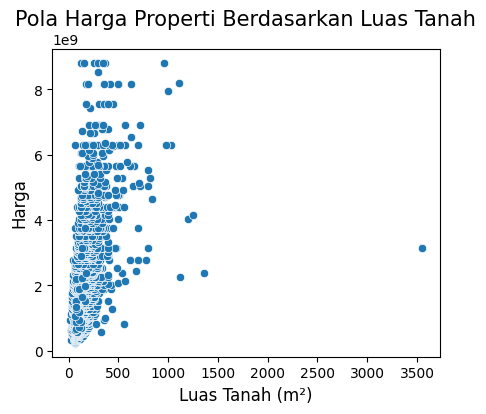

In [59]:
# Visualisasi hubungan antara Luas Tanah dan Harga
plt.figure(figsize=(5,4))
sns.scatterplot(x='Luas Tanah', y='Harga', data=df)
plt.title('Pola Harga Properti Berdasarkan Luas Tanah', fontsize=15)
plt.xlabel('Luas Tanah (m²)', fontsize=12)
plt.ylabel('Harga', fontsize=12)
plt.show()

Untuk memberikan visual yang lebih baik, outlier akan dihandle non-permanen

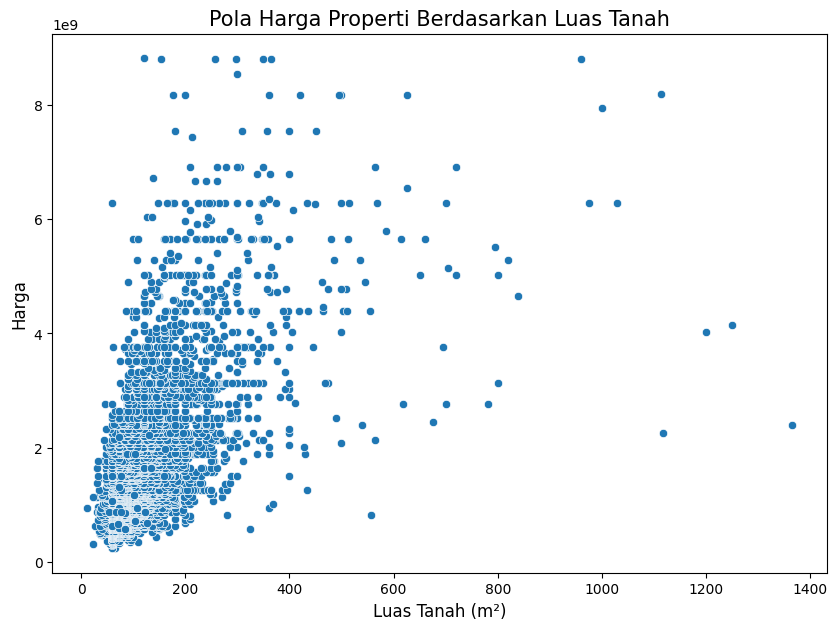

In [60]:
# Drop outlier sementara
max = df['Luas Tanah'].max()
idx = df[df['Luas Tanah'] == max].index[0] 
dx = df.drop(idx)

# Visualisasi hubungan antara Luas Tanah dan Harga
plt.figure(figsize=(10,7))
sns.scatterplot(x='Luas Tanah', y='Harga', data=dx)
plt.title('Pola Harga Properti Berdasarkan Luas Tanah', fontsize=15)
plt.xlabel('Luas Tanah (m²)', fontsize=12)
plt.ylabel('Harga', fontsize=12)
plt.show()

Gambar di atas merupakan scatter plot yang menggambarkan hubungan antara Luas Tanah (m²) dengan Harga Properti (dalam miliar rupiah). Berikut informasi yang dapat diamati:
  - Mayoritas properti memiliki luas tanah di bawah 400 m².
  - Banyak properti dengan harga tinggi meskipun luas tanahnya relatif kecil → menunjukkan adanya pengaruh faktor lain seperti lokasi, kondisi bangunan, atau fasilitas.
  - Secara umum terlihat tren naik — semakin besar luas tanah, harga cenderung lebih tinggi, namun hubungan ini tidak linier.

### Korelasi antar numerik variabel

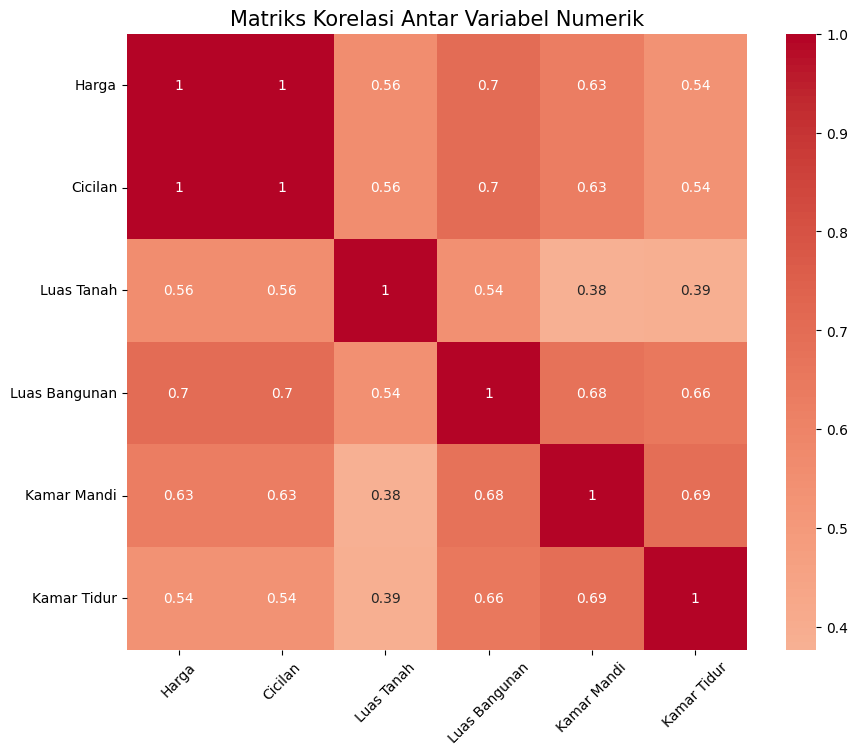

In [61]:
# Visualisasi hubungan antara Variabel Numerik dan Harga
plt.figure(figsize=(10, 8))
corr_matrix = df.select_dtypes(include=np.number).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriks Korelasi Antar Variabel Numerik', fontsize=15)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

| Nilai Korelasi (r) | Kekuatan Hubungan           |
|--------------------|-----------------------------|
| 0.0 – 0.3          | Lemah                       |
| 0.3 – 0.5          | Sedang                      |
| 0.5 – 0.7          | kuat                        |
| 0.7 – 1.0          | Sangat kuat                 |

Dari Heatmap diatas dapat diamati bahwa sebagian besar variabel numerik menunjukkan korelasi yang kuat dan sangat kuat, kecuali hubungan antara luas tanah dengan jumlah kamar (baik kamar mandi maupun kamar tidur)

| Hasil | Interpretasi         |
|--------------------|-----------------------------|
| Harga  sangat berkorelasi dengan semua variabel | semakin besar ukuran bangunan dan semakin banyak fasilitas di dalam rumah, maka harga properti cenderung semakin tinggi (begitu juga dengan cicilan)|
| Luas tanah berkorelasi lemah dengan jumlah kamar | luas lahan tidak secara langsung menentukan jumlah kamar (tidur dan mandi). Namun jumlah kamar  menunjukkan korelasi yang jauh lebih tinggi terhadap luas bangunan, yang mengindikasikan bahwa desain rumah lebih mengandalkan pemanfaatan ruang bangunan (vertikal/horizontal) dibanding luas tanah yang tersedia |

**Rekomendasi**

| Stakeholder         | Insight / Rekomendasi                                                                 |
|---------------------|----------------------------------------------------------------------------------------|
| Developer Properti  | Fokus pengembangan sebaiknya diarahkan pada efisiensi tata ruang dalam bangunan, bukan hanya luas kavling.    |
| Tim Pricing / Model | Jumlah kamar lebih tepat diprediksi dari luas bangunan, bukan dari luas tanah.       |
| Konsumen            | Edukasi bahwa luas tanah besar belum tentu berarti rumah lebih luas atau lebih banyak kamar. |


## Feature Engineering

### Cardinality Check

In [62]:
# Cek Cardinality
container = []
for col in df.columns:
  container.append([col, df[col].nunique(), df[col].unique()])

cardinal = pd.DataFrame(columns=['kolom', 'nunique', 'unique_values'], data=container)
cardinal

,kolom,nunique,unique_values
0,Nama Rumah,4252,"[Kebun Raya Residence Cluster Cipta Park 1, El..."
1,Harga,344,"[870000000, 960000000, 1280000000, 1140000000,..."
2,Cicilan,318,"[8400000, 9200000, 12300000, 11000000, 1470000..."
3,Lokasi,156,"[Ciomas, Pancoran mas, Ciputat, Bogor barat, C..."
4,Kota,10,"[bogor, depok, tangerang selatan, jakarta bara..."
5,Tipe,2,"[Kabupaten, Kota]"
6,Luas Tanah,378,"[96, 72, 125, 91, 84, 112, 108, 67, 78, 90, 10..."
7,Luas Bangunan,292,"[54, 100, 112, 91, 99, 72, 123, 47, 52, 57, 42..."
8,Kamar Mandi,11,"[1, 2, 3, 4, 5, 6, 7, 9, 10, 8, 15]"
9,Kamar Tidur,11,"[2, 3, 4, 1, 5, 6, 7, 8, 9, 10, 20]"


***Insight***

Pada pengecekan cardinality ini, diharapkan dapat mereduksi fitur kategorikal dengan kardinalitas tinggi yang dapat menimbulkan gangguan, sehingga tidak membawa informasi berarti dan membuat model rentan overfitting. Pada dataset ini, kolom `Nama Rumah` memiliki cardinality yang sangat tinggi, yaitu sebanyak 4.252 nilai unik. Hal ini menunjukkan bahwa terdapat banyak variasi properti yang berbeda-beda secara spesifik. Karena tingkat variasi yang sangat tinggi dan sifatnya yang hampir seperti identifier unik, fitur ini berpotensi memberikan kontribusi minimal terhadap model prediktif dan dapat dipertimbangkan untuk dihapus guna mengurangi kompleksitas tanpa mengorbankan performa model.

### Split Train-Test

In [63]:
df.head()

,Nama Rumah,Harga,Cicilan,Lokasi,Kota,Tipe,Luas Tanah,Luas Bangunan,Kamar Mandi,Kamar Tidur
0,Kebun Raya Residence Cluster Cipta Park 1,870000000,8400000,Ciomas,bogor,Kabupaten,96,54,1,2
1,El Fatih Land Pancoran mas F1,960000000,9200000,Pancoran mas,depok,Kota,72,100,2,3
2,Komplek Depkes,1280000000,12300000,Ciputat,tangerang selatan,Kota,125,112,3,3
3,Perumahan Taman Yasmin Sektor 1,1140000000,11000000,Bogor barat,bogor,Kota,91,91,1,2
4,Metland Cileungsi,1530000000,14700000,Cileungsi,bogor,Kabupaten,84,99,2,3


In [64]:
# Split `X` and `y`
X = df.drop(['Harga','Cicilan','Nama Rumah'], axis=1)
y = df['Harga']
X

,Lokasi,Kota,Tipe,Luas Tanah,Luas Bangunan,Kamar Mandi,Kamar Tidur
0,Ciomas,bogor,Kabupaten,96,54,1,2
1,Pancoran mas,depok,Kota,72,100,2,3
2,Ciputat,tangerang selatan,Kota,125,112,3,3
3,Bogor barat,bogor,Kota,91,91,1,2
4,Cileungsi,bogor,Kabupaten,84,99,2,3
...,...,...,...,...,...,...,...
5757,Pondokmelati,bekasi,Kota,162,150,2,3
5758,Ciputat timur,tangerang selatan,Kota,130,170,4,3
5759,Larangan,tangerang,Kota,180,150,2,4
5760,Sukmajaya,depok,Kota,120,230,3,4


In [65]:
# Split Train-Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

print('Train size : ', X_train.shape)
print('Test size  : ', X_test.shape)

Train size :  (4609, 7)
Test size  :  (1153, 7)


- Variabel Nama rumah bersifat kategorikal non-informatif dan tidak memiliki korelasi langsung terhadap harga, oleh karena itu fitur ini dihapus dari dataset.
- Sementara itu, Cicilan memiliki korelasi sangat tinggi dengan variabel target (Harga). Karena fitur ini dihitung berdasarkan harga dan berpotensi menyebabkan data leakage, maka Cicilan juga dihapus dari dataset sebelum proses pelatihan model.
- Data displit jadi Train dan Test, dimana data Train digunakan untuk pembelajaran model, dan akan diuji pada data Test. Proporsi pembagiannya 80-20 untuk Train-Test

### Outlier

In [66]:
# Cek kemiringan distribusi kolom numerik
numcols = X_train.select_dtypes(include=np.number).columns.to_list()
skew_category = []
skew_values = []

for col in numcols:
    skew_val = X_train[col].skew()
    skew_values.append(round(skew_val, 2)) 
    
    if -0.5 <= skew_val <= 0.5:
        skew_category.append('Normal')
    elif (0.5 < skew_val <= 1) or (-1 < skew_val < -0.5):
        skew_category.append('Skew')
    else:
        skew_category.append('Extreme Skew')

# DataFrame
skew_df = pd.DataFrame({
    'Kolom': numcols,
    'Skewness': skew_values,
    'Kategori': skew_category
})

skew_df

,Kolom,Skewness,Kategori
0,Luas Tanah,11.44000,Extreme Skew
1,Luas Bangunan,2.12000,Extreme Skew
2,Kamar Mandi,1.52000,Extreme Skew
3,Kamar Tidur,2.00000,Extreme Skew


In [67]:
# Fungsi cek jumlah outlier (IQR)
def count_outliers_iqr(df, numcols):
    outlier_counts = []

    for col in numcols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR        
        jumlah_outlier = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outlier_counts.append(jumlah_outlier)

    data = {
        'Kolom': numcols,
        'Jumlah_Outlier': outlier_counts
    }
    return pd.DataFrame(data=data)

numcols = X_train.select_dtypes(include=np.number).columns.to_list()
outlier_summary = count_outliers_iqr(X_train, numcols)
outlier_summary

,Kolom,Jumlah_Outlier
0,Luas Tanah,328
1,Luas Bangunan,177
2,Kamar Mandi,12
3,Kamar Tidur,418


- Skewness : Semua fitur numerik (Luas Tanah, Luas Bangunan, Kamar Mandi, Kamar Tidur) memiliki skewness ekstrem, menunjukkan distribusi data yang sangat tidak simetris dengan nilai-nilai jauh dari pusat.
- Outlier  : Jumlah outlier cukup banyak terutama pada Luas Tanah (120) dan Kamar Tidur (48), sedangkan Kamar Mandi relatif sedikit (2). Hal ini menunjukkan variasi ekstrem pada beberapa fitur.
- Implikasi : Perlu penanganan khusus seperti transformasi data dan scaling yang tepat untuk mengurangi dampak skewness dan outlier agar model prediksi lebih akurat dan tidak bias.



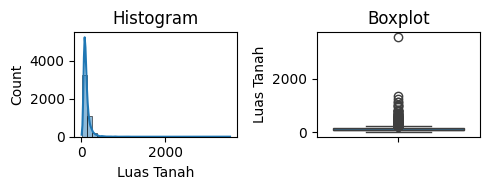

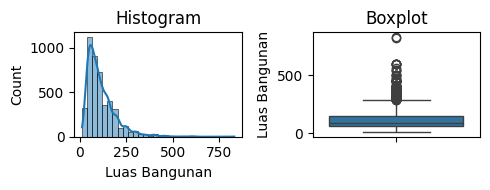

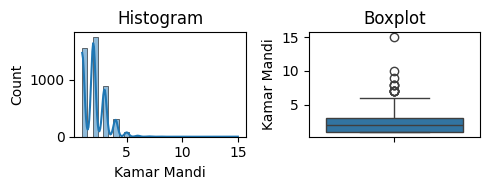

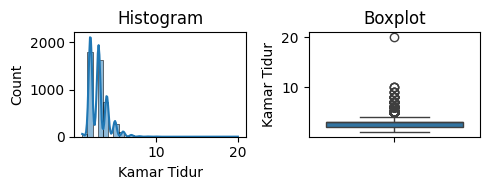

In [68]:
# Fungsi membuat histogram dan boxplot
def diagnostic_plots(df, variable):
    plt.figure(figsize=(5,2))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30,kde=True)
    plt.title('Histogram')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    plt.subplots_adjust(wspace=0.3)

    plt.tight_layout()
    plt.show()
    
# Sebelum handling
for i in numcols:
    diagnostic_plots(X_train, i)

In [69]:
# Handle  outliers dengan capping (Winsor)
X_train[numcols] = X_train[numcols].astype(float)
X_test[numcols] = X_test[numcols].astype(float)

winsor_ext = Winsorizer(capping_method='iqr',
                            tail='both',
                            fold=1.5,
                            variables=numcols,
                            missing_values='ignore')

X_train_capped = winsor_ext.fit_transform(X_train)
X_test_capped = winsor_ext.transform(X_test)

Jika data berdistribusi normal, outlier dapat diidentifikasi menggunakan batas mean ± 3 × standar deviasi. Namun data berdistribusi skew atau tidak normal, outlier ditentukan dengan menggunakan batas kuartil (Q1 dan Q3) serta rentang interkuartil (IQR), yaitu nilai di luar Q1 - 1.5×IQR dan Q3 + 1.5×IQR. Maka fold yang digunakan adalah 1.5

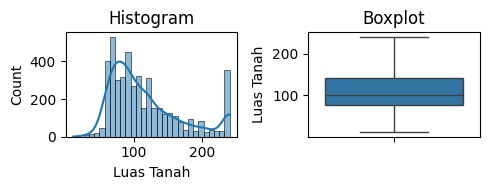

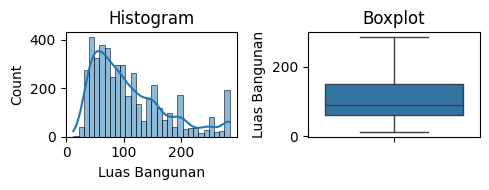

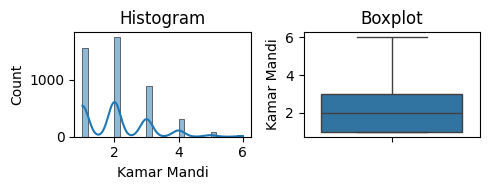

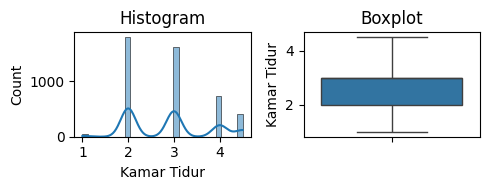

In [70]:
# Historgram & Boxplot setelah handling
for i in numcols:
    diagnostic_plots(X_train_capped, i)

In [71]:
# Cek outlier setelah Winsorization
outlier_summary2 = count_outliers_iqr(X_train_capped, numcols)
outlier_summary2

,Kolom,Jumlah_Outlier
0,Luas Tanah,0
1,Luas Bangunan,0
2,Kamar Mandi,0
3,Kamar Tidur,0


### Encoding & Scaling

In [72]:
# Pisahkan kolom numerik dan kategorik
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

print("Kolom Numerik:", numerical_cols)
print("Kolom Kategorik:", categorical_cols)

Kolom Numerik: Index(['Luas Tanah', 'Luas Bangunan', 'Kamar Mandi', 'Kamar Tidur'], dtype='object')
Kolom Kategorik: Index(['Lokasi', 'Kota', 'Tipe'], dtype='object')


In [73]:
# Scaling dan Encoding dengan transformer pipeline
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore')

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_cols),
        ('cat', encoder, categorical_cols)
    ]
)

# Fit & Transform
X_train_preprocessed = preprocessor.fit_transform(X_train_capped)
X_test_preprocessed = preprocessor.transform(X_test_capped)

## Modeling

### Model Definition

In [74]:
# Model yang akan digunakan
model_linreg = LinearRegression()
model_lasso = Lasso()
model_ridge = Ridge()
model_elastic = ElasticNet()
model_svr = SVR(kernel='rbf')
model_rf = RandomForestRegressor(random_state=7)

Dalam percobaan ini, kami melakukan evaluasi berbagai algoritma regresi untuk memodelkan harga rumah, termasuk regresi linier sederhana, teknik regularisasi (Lasso, Ridge, ElasticNet), serta metode ensemble seperti Random Forest.

Setiap model diuji dengan berbagai konfigurasi parameter untuk mengidentifikasi pengaruh variabel kontrol dan mengoptimalkan performa prediksi. Pendekatan ini bertujuan untuk menemukan model yang paling tepat dalam menangkap pola data serta memberikan estimasi harga yang akurat dan generalisasi baik pada data uji.

### Model Training

In [75]:
# Linear Regression
model_linreg.fit(X_train_preprocessed, y_train)

LinearRegression()

In [76]:
# Lasso regularization
model_lasso.fit(X_train_preprocessed, y_train)

Lasso()

In [77]:
# Ridge Regularization
model_ridge.fit(X_train_preprocessed, y_train)

Ridge()

In [78]:
# ElasticNet Regularization
model_elastic.fit(X_train_preprocessed, y_train)

ElasticNet()

In [79]:
# Support Vector Regression
model_svr.fit(X_train_preprocessed, y_train)

SVR()

In [80]:
# Random Forest Regressor
model_rf.fit(X_train_preprocessed, y_train)

RandomForestRegressor(random_state=7)

### Model Evaluation

In [81]:
# Fungsi evaluasi
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name=""):
    # Predict on training and test sets
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Metrics calculation
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)    
 
    # Return metrics as dictionary if needed
    return {
        'model_name': model_name,
        'mae_train': mae_train,
        'mae_test': mae_test,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'r2_train': r2_train,
        'r2_test': r2_test,
    }

In [82]:
# models
models = {
    'Linear Regression': model_linreg,
    'Lasso': model_lasso,
    'Ridge': model_ridge,
    'ElasticNet': model_elastic,
    'SVR': model_svr,
    'Random Forest': model_rf
}

# Evaluasi model
results = []
for name, model in models.items():
    result = evaluate_model(model, X_train_preprocessed, y_train, 
                          X_test_preprocessed, y_test, model_name=name)
    results.append(result)

In [83]:
pd.set_option('display.float_format', '{:.5f}'.format)

result_df = pd.DataFrame(results)
result_df

,model_name,mae_train,mae_test,rmse_train,rmse_test,r2_train,r2_test
0,Linear Regression,418776878.61685,431504372.47194,623908537.05580,665456145.19988,0.73701,0.65965
1,Lasso,418782579.64743,431424218.07392,623908790.41372,666028162.45816,0.73701,0.65907
2,Ridge,420710668.69983,427378806.96386,626084889.97249,652723165.39561,0.73517,0.67255
3,ElasticNet,487829434.49314,482444402.68821,765279184.98403,747162451.47787,0.60433,0.57095
4,SVR,816819777.23032,783139412.94770,1290313497.87151,1210142039.74558,-0.12483,-0.12552
5,Random Forest,157732519.36608,410055865.92169,251591043.67767,657649542.93057,0.95724,0.66759


In [ ]:
# Cek rata-rata harga
mean = df['Harga'].mean()
print(f"Rata-rata Harga Rumah: {mean:.2f}")

Rata-rata Harga Rumah: 1684700885.11


**Random Forest**
- MAE Train meleset sangat sedikit (sekitar 9%) dari rata-rata harga rumah untuk train, namun tidak stabil ketika di test
- R² Train sangat tinggi (0.957) → menunjukkan model hampir sempurna di data training.
- Namun R² Test menurun signifikan (0.667) → mengindikasikan terjadi `overfitting`.
- Dalam prediksi harga rumah, overfit bisa menyebabkan kesalahan yang cukup merugikan saat digunakan di luar sampel data training.

**Ridge Regression**
- MAE cukup besar sekitar 25% dari rata-rata harga rumah, namun cukup stabil di train-test
- Menjelaskan sekitar 67% variasi harga rumah pada data test.
- Memiliki selisih R² Train-Test kecil (0.735 → 0.672) → menunjukkan model stabil dan tidak overfit.
- Mampu memberikan estimasi harga rumah yang cukup akurat untuk data baru.

Regresi dengan regularisasi Ridge adalah model paling direkomendasikan, karena ada keseimbangan antara akurasi dan generalisasi Train-Test. Random Forest memiliki potensi kuat, namun saat ini tidak stabil tanpa tuning lebih lanjut. Dalam kasus properti bernilai tinggi, stabilitas prediksi dan keakuratan untuk data baru relatif lebih penting daripada performa pada data train saja.

### Hyperparameter tuning

#### Random Forest Regressor

In [85]:
# Define model dasar
rf = RandomForestRegressor(random_state=7)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],              
    'max_depth': [None, 5, 10],         
    'min_samples_split': [2, 5, 10],         
    'min_samples_leaf': [1, 2, 5],           
    'max_features': ['auto', 'sqrt']        
}

# GridSearch
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='r2',                
    cv=5,
)

# Fit ke data train
grid_search.fit(X_train_preprocessed, y_train)

# Hasil terbaik
print("Best parameters:", grid_search.best_params_)
print("Best R² score on CV:", grid_search.best_score_)

# Prediksi di train dan test
best_rf = grid_search.best_estimator_

y_train_pred = best_rf.predict(X_train_preprocessed)
y_test_pred = best_rf.predict(X_test_preprocessed)

# Hitung metrik
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Hasil evaluasi
print("MAE Train RF:", mae_train)
print("MAE Test RF:", mae_test)
print("RMSE Train RF:", rmse_train)
print("RMSE Test RF:", rmse_test)
print("R² Train RF:", r2_train)
print("R² Test RF:", r2_test)


Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best R² score on CV: 0.7152340821799781
MAE Train RF: 252419109.81630445
MAE Test RF: 404096600.2015796
RMSE Train RF: 399275394.8666948
RMSE Test RF: 643149432.5215862
R² Train RF: 0.8922934835777179
R² Test RF: 0.6820895553513933


#### Ridge Regularization

In [86]:
# Define model
ridge = Ridge()

# Parameter
param_grid = {
    'alpha': [10,30,50,100],   
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag'],
    'max_iter': [100, 500, 1000, 5000]
}

# GridSearch
grid_search_2 = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
)

# Fit ke data train
grid_search_2.fit(X_train_preprocessed, y_train)

# Hasil terbaik
print("Best parameters:", grid_search_2.best_params_)
print("Best R² score on CV:", grid_search_2.best_score_)

# Prediksi di train dan test
best_ridge = grid_search_2.best_estimator_

y_train_pred_2 = best_ridge.predict(X_train_preprocessed)
y_test_pred_2 = best_ridge.predict(X_test_preprocessed)

# Hitung metrik evaluasi
mae_train_2 = mean_absolute_error(y_train, y_train_pred_2)
mae_test_2 = mean_absolute_error(y_test, y_test_pred_2)
rmse_train_2 = mean_squared_error(y_train, y_train_pred_2, squared=False)
rmse_test_2 = mean_squared_error(y_test, y_test_pred_2, squared=False)
r2_train_2 = r2_score(y_train, y_train_pred_2)
r2_test_2 = r2_score(y_test, y_test_pred_2)

# Hasil evaluasi
print("MAE Train:", mae_train_2)
print("MAE Test:", mae_test_2)
print("RMSE Train:", rmse_train_2)
print("RMSE Test:", rmse_test_2)
print("R² Train:", r2_train_2)
print("R² Test:", r2_test_2)


Best parameters: {'alpha': 10, 'max_iter': 100, 'solver': 'lsqr'}
Best R² score on CV: 0.701948968709039
MAE Train: 425878021.8644115
MAE Test: 425387471.54921436
RMSE Train: 640670290.5854477
RMSE Test: 644681017.8713502
R² Train: 0.7226896657582396
R² Test: 0.6805736192065492


Untuk mendapatkan gambaran model mana yang memiliki performa terbaik, maka dibandingkan 2 model yaitu **Random Forest** dan **Ridge Regression** melalui proses **hyperparameter tuning** dengan Grid Search dan Cross-Validation (5-fold). 
- GridSearchCV digunakan untuk mencari kombinasi parameter terbaik yang menghasilkan nilai R² tertinggi di data training.
- Setelah tuning, model terbaik dari masing-masing algoritma dievaluasi kembali pada data training dan data testing.
- Hasil tuning menunjukkan perbaikan pada masing-masing model namun tidak signifikan. Sekitar XXXXX pada random forest, dan XXXXX pada Ridge Regression.
- Secara stabilitas model dan hasil evaluasi pada test-set, Ridge Regression menunjukkan hasil yang lebih baik.

| Metrik            | Sebelum Tuning        | Sesudah Tuning        |
|-------------------|-----------------------|-----------------------|
| **MAE (Train - Test)** | 420 juta - 427 juta   | 425 juta - 425 juta    |
| **R² (Train - Test)**  | 0.735 - 0.672         | 0.722 - 0.680          |

Maka diperoleh kesimpulan sebagai berikut:
- Tuning hyperparameter berhasil meningkatkan keseimbangan antara performa pada data train dan test.
- Model menjadi lebih stabil dan mengurangi overfit, meskipun performa di train sedikit turun, performa di test meningkat.
- Perbaikan R² test dan penurunan selisih MAE antara train dan test menunjukkan model lebih handal untuk prediksi data baru.

## Assumptions Check

### 1. Linear Relationship

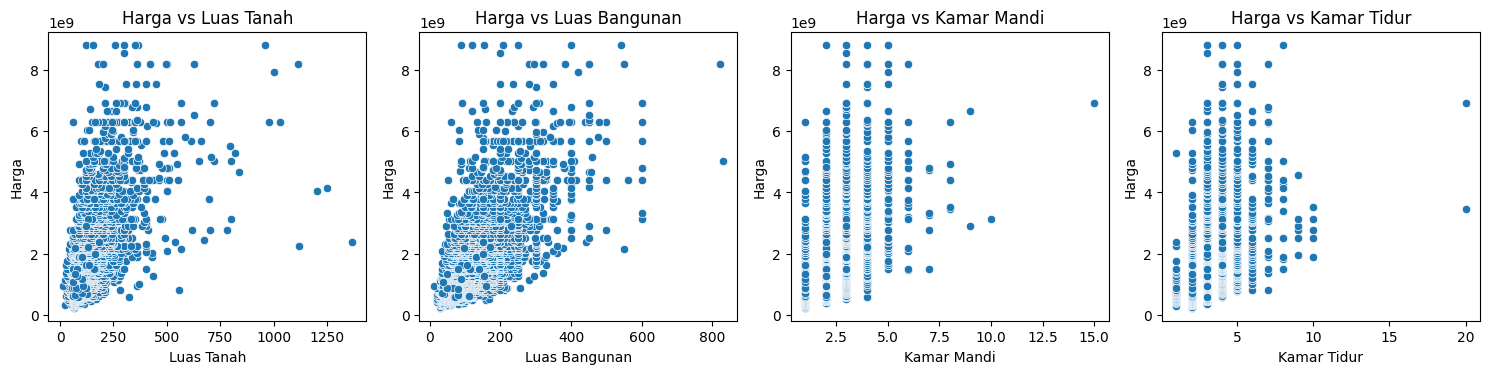

In [87]:
# Visualisasi hubungan antara Harga dan kolom numerik
plt.figure(figsize=(15, 4))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, len(numerical_cols), i)
    sns.scatterplot(data=dx, x=col, y='Harga')
    plt.title(f'Harga vs {col}')
    plt.xlabel(col)
    plt.ylabel('Harga')

plt.tight_layout()
plt.show()

Scatterplot menunjukkan gambaran pola yang menyebar, dan ada variasi cukup besar pada harga untuk fitur pada dengan nilai yang sama. Hal tersebut menunjukkan hubungan yang `tidak linear` antar tiap fitur dengan targetnya, sehingga hal ini melanggar asumsinya, maka akan berdampak pada akurasi, interpretasi, dan validitas model.

### 2. Multicolinearity (VIF)

In [88]:
# Perhitungan VIF (Variance Inflation Factor)

numerical_X = X[numerical_cols]
numerical_X = numerical_X.reset_index(drop=True)

def calc_vif(X):
    X = X.apply(pd.to_numeric, errors='coerce')
    if X.isna().any().any():
        X = X.fillna(0)
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(0)     
    X_array = X.astype(float).values
    
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X_array, i) for i in range(X.shape[1])]
    
    return vif

calc_vif(numerical_X)

,variables,VIF
0,Luas Tanah,3.68949
1,Luas Bangunan,7.58324
2,Kamar Mandi,10.79823
3,Kamar Tidur,10.68325


VIF (Variance Inflation Factor) yang lebih dari 5 atau 10 menunjukkan adanya multikolinearitas (dua atau lebih variabel independen dalam model regresi saling berkorelasi tinggi) dalam model:
- VIF < 5 (Luas Tanah: 3.689):
    Multikolinearitas rendah, fitur ini cukup independen dan tidak bermasalah.

- VIF antara 5–10 (Luas Bangunan: 7.583):
    Terdapat indikasi multikolinearitas sedang, perlu diperhatikan karena bisa mempengaruhi stabilitas koefisien regresi.

- VIF > 10 (Kamar Mandi: 10.798, Kamar Tidur: 10.683):
    Ada multikolinearitas tinggi, fitur ini sangat berkorelasi dengan fitur lain dan bisa menyebabkan model regresi kurang stabil dan interpretasi koefisien jadi kurang jelas. 

Nilai VIF menunjukkan 3 dari 4 fitur berada diatas 5.00 sehingga terdapat multikolinearitas. Artinya variabel-variabel numerik independen dalam model regresi tidak bebas atau saling berkorelasi satu sama lain.

### 3. Multivariate Normality

In [89]:
# Cek residual
y_test_residuals = y_test - y_test_pred_2
y_test_residuals

5121   -252418385.41798
5222    720226327.63722
345    -160949339.09072
4912   1430457121.27000
2984   -145073556.04990
             ...       
4512   -318191301.72649
3648   -697205942.56384
1483    285764799.09924
4867    155797232.05756
4623    656880014.14393
Name: Harga, Length: 1153, dtype: float64

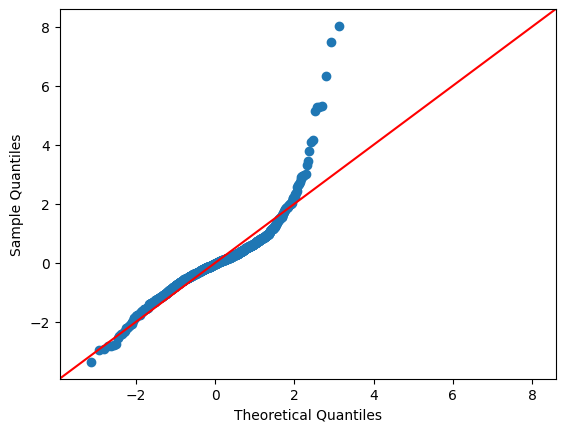

In [90]:
# Cek normalitas residual dengan QQ plot
residuals_std = zscore(y_test_residuals) 
sm.qqplot(residuals_std, line='45')
plt.show()

Dari QQ plot diatas nampak pola membentuk huruf S yang menandakan Distribusi residual tidak normal. Titik yang menjauhi garis (terutama di ekor atas) menunjukkan right-skewed / long right tail yang menunjukkan ada beberapa nilai residual yang sangat besar (outlier positif) dibanding sisanya. Model sering salah menilai aktual rumah yang mahal → hasil prediksinya terlalu rendah → residual besar. Hal ini menandakan `asumsi normalitas residual dilanggar` yang berdampak pada performa model.

### 4. No Auto-Correlation

In [91]:
# Durbin-Watson Test
durbin_watson(y_test_residuals)

2.003342407938162

Nilai exact pada Durbin-Watson Test adalah `d=2` dimana dapat dikatakan tidak ada autokorelasi, karena hasil (2.003...) menunjukkan sangat dekat dengan nilai ini maka dapat diartikan tidak terjadi autokorelasi pada residual. Secara umum nilai yang berada dalam rentang 1,5 hingga 2,5 dapat dianggap bahwa autokorelasi tidak menjadi masalah dalam model regresi ini. 

### 5. Homoscedasticity test

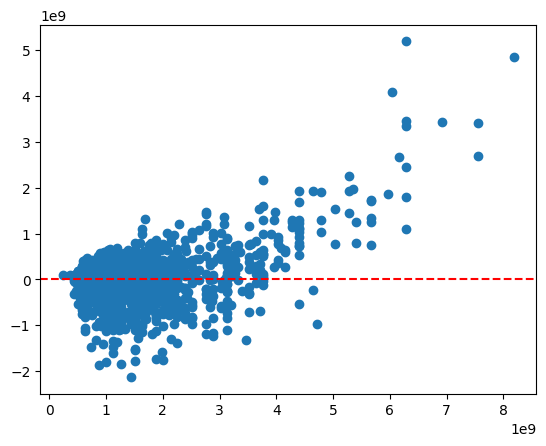

In [92]:
# Cek homoscedasticity dengan scatter plot
plt.scatter(y_test, y_test_residuals)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.show()

Kita dapat melihat bahwa `y_test_residuals` dan `y_test` membentuk pola berkumpul di suatu tempat.
Residual tersebar tidak merata di seluruh rentang nilai prediksi
kecenderungan semakin besar nilai prediksi, semakin menyebar residualnya
Banyak residual terkonsentrasi di sekitar nilai prediksi kecil, dan semakin menyebar ke atas/bawah seiring membesar nilai prediksi.



Hal ini menunjukkan adanya indikasi heteroskedastisitas, dimana varians residual yang digambarkan tidak konstan. Dengan demikian, asumsi homoskedastisitas juga dilanggar dalam model ini.

| **Asumsi** | **Kondisi** | **Interpretasi** | **Dampak** |
|-------------|---------------|------------------|------------|
| **Asumsi Linearitas** | Scatter fitur-harga berbentuk corong | Hubungan non-linear antara fitur2 dan target | Model linear tidak dapat menangkap pola data dengan baik, model bias di harga tinggi |
| **Multikolinearitas** | VIF tinggi: 7, 10, 10 (3 dari 4 fitur) | Fitur-fitur berkorelasi kuat satu sama lain | • Koefisien tidak stabil<br>• Standard error membesar |
| **Normalitas Residual** | QQ plot S-shape, titik menjauhi garis di ekor atas | Residual right-skewed/long right tail | Model underpredict harga tinggi|
| **Autokorelasi** | Durbin-Watson = 2.0045 | Tidak ada autokorelasi ✅ | Tidak ada masalah ✅ |
| **Heteroskedastisitas** | Residual menyebar seiring nilai prediksi membesar | Varians residual tidak konstan| • Standard error bias<br>• Kesulitan prediksi untuk nilai tinggi |

## Conclusion

### Proses:

1. **Data Scraping**  
   Mengumpulkan data dari platform jual-beli rumah `pashouse` melalui proses web scraping dengan beautifulsoup.

2. **Data Cleaning & Preparation**  
   Melakukan pembersihan data mentah untuk menghilangkan missing values, duplikasi, dan inkonsistensi sehingga menghasilkan dataset yang siap digunakan.

3. **Exploratory Data Analysis (EDA)**  
   Menganalisis karakteristik data secara visual dan statistik untuk memahami distribusi, hubungan antar fitur, serta mendeteksi anomali atau pola penting.

4. **Data Splitting**  
   Membagi dataset menjadi data pelatihan (training set) dan data pengujian (test set) untuk evaluasi model yang adil dan tidak bias.

5. **Outlier Handling**  
   Menerapkan teknik winsorization pada kolom numerik untuk mengurangi dampak outlier, dengan fitting pada data training dan transformasi dilakukan pada data training dan testing.

6. **Feature Engineering & Scaling**  
   Melakukan encoding fitur kategori menggunakan One-Hot Encoding dan standarisasi fitur numerik menggunakan StandardScaler untuk memastikan skala fitur yang konsisten.

7. **Modeling & Comparison**  
   Membangun dan membandingkan berbagai model regresi, termasuk Linear Regression, Regularisasi (Lasso, Ridge, ElasticNet), Polynomial Regression, Support Vector Regression (SVR), dan Random Forest Regressor.

8. **Hyperparameter Tuning**  
   Melakukan optimasi parameter model menggunakan GridSearchCV untuk mendapatkan kombinasi parameter terbaik yang meningkatkan performa model.

9. **Assumptions check**   
   Mengidentifikasi pelanggaran asumsi yang dapat menyebabkan bias, ketidakstabilan koefisien, dan prediksi yang kurang akurat, sehingga memungkinkan perbaikan model agar performa dan interpretasinya lebih baik.


### Hasil:

1. **Model terbaik**  
   `Random forest` dipilih untuk dituning karena memiliki performa yang baik di train-set, dan berpotensi ada optimasi setelah tuning & `Ridge Regression` dipilih karena memberikan performa yang lebih stabil, dengan selisih error yang kecil antara data train dan test.

2. **Kompleksitas Model dan Risiko Overfitting**  
   `Random Forest` merupakan model kompleks dan non-linear yang memiliki kecenderungan overfitting, terutama jika dataset terbatas atau fitur kurang informatif. Sebaliknya, `Ridge Regression` dengan regularisasi L2 lebih stabil karena membatasi besarnya koefisien model.

3. **Pengaruh Noise terhadap Model**  
   Dataset menunjukkan adanya noise yang cukup tinggi atau fitur-fitur yang kurang relevan. Ridge Regression membantu mengurangi dampak noise melalui regularisasi, sedangkan Random Forest lebih sensitif terhadap noise karena fleksibilitas model yang tinggi.

4. **Ukuran Dataset dan Efisiensi Model**  
   Pada dataset yang relatif kecil, model linier dengan regularisasi (seperti Ridge) sering kali lebih unggul karena lebih sederhana, lebih cepat dilatih, dan dapat melakukan generalisasi lebih baik dibanding model kompleks.

5. **Kemungkinan Penyebab Hasil Kurang Optimal**  
   Performa yang rendah pada beberapa model dapat disebabkan oleh fitur yang kurang informatif, jumlah data yang belum mencukupi, atau konfigurasi parameter yang belum optimal.

6. **Perbandingan Kinerja Model**  
   Dari enam model yang diuji, dua model perlu diperhatikan:  
   - **Random Forest** : error pada data train yang sangat rendah dengan nilai R² train tinggi, namun terdapat selisih signifikan pada data test, mengindikasikan overfitting.  
   - **Ridge Regression** : performa lebih stabil dengan gap train-test yang lebih kecil. Ini menunjukkan efek positif dari regularisasi L2 dalam mengontrol kompleksitas model.

7. **Pelanggaran Asumsi Model Linier**  
   Sebanyak 4 dari 5 asumsi regresi linear tidak terpenuhi, yang menunjukkan bahwa model linier masih memiliki keterbatasan dalam menangkap pola data secara optimal, terutama pada prediksi harga tinggi.
   

### Rekomendasi

1. **Outlier**  
  Optimalkan penanganan outlier. Regresi sangat terpengaruh oleh outlier dalam dataset.

2. **Transformasi variabel**  
  Pertimbangkan menggunakan log transformasi pada variabel numerik dengan distribusi miring untuk mengurangi skewness dan dampak outlier

3. **Feature Engineering**  
  Tambahkan fitur baru seperti rasio luas bangunan/tanah, total kamar, atau cluster lokasi untuk memperkaya informasi model.

4. **Variabel Kategorik**  
  Fitur lokasi memiliki cardinality yang cukup besar sehingga bisa dipertimbangkan teknik encoding lain seperti Target Encoding, agar model dapat menangkap pola dengan lebih baik.

5. **Feature Selection**  
  Gunakan metode seleksi fitur (misal RFE atau feature importance) untuk mengeliminasi fitur kurang relevan dan mengurangi noise.

6. **Cross-Validation**  
  Terapkan k-fold cross-validation untuk evaluasi model yang lebih stabil dan menghindari overfitting.

7. **Model Ensemble / Advanced Models**  
  Eksplorasi model lain seperti Gradient Boosting (XGBoost, LightGBM) atau teknik stacking.

8. **Hyperparameter Tuning Lebih Luas**  
  Gunakan RandomizedSearchCV dan perluas ruang pencarian parameter untuk mendapatkan kombinasi terbaik.

9. **Transformasi Target**  
  Pertimbangkan transformasi log pada target harga untuk mengurangi skew dan mengoptimalkan kualitas prediksi.

10. **PCA**  
  Pertimbangkan menggunakan PCA untuk mengurangi nilai VIF.